# PHYS3009: TeV Astronomy Project

Name: 

Student No.:

total marks: 53

In this project you will do yourself the data analysis of the object 
RX J1713.7-3946. You mainly need to copy and paste code from the Crab Nebula notebook which we have discussed in the lecture, and make the necessary changes for the new source. You will be provided with example output so that you can check your results. Please put your code in the cells starting with 

```
# your code here
```

You do not need to edit any other cells. If you want to add additional ouput, or test some things you can create new cells for that.

## Preparation

### Imports
Let's start with importing the modules that we used in the last notebook.

In [ ]:
import matplotlib.pyplot as plt

from numpy import sqrt

import astropy.units as u

from astropy.coordinates import (
    SkyCoord, 
    Angle,
)


from gammapy.utils.check import check_tutorials_setup

from gammapy.data import (
    DataStore,
    EventList,
)

from gammapy.stats import WStatCountsStatistic

from gammapy.maps import Map, MapAxis, WcsGeom, RegionGeom

In [ ]:
from gammapy.datasets import MapDataset, Datasets, SpectrumDataset, FluxPointsDataset

from gammapy.makers import (
    MapDatasetMaker, 
    RingBackgroundMaker, 
    SafeMaskMaker, 
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker
)

from regions import CircleSkyRegion

from gammapy.modeling.models import PowerLawSpectralModel, ExpCutoffPowerLawSpectralModel, SkyModel

from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.modeling import Fit

import numpy as np

import scipy.stats


### Data download
The following lines check the setup and download the data.

In [ ]:
check_tutorials_setup()

In [ ]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/1.1/hess-dl3-dr1")

In [ ]:
data_store.info()

Expected output:

```
Data store:
HDU index table:
BASE_DIR: gammapy-data/1.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105
```

### Run Selection

You can find the position of RX J1713.7-3946 on TeVCat: http://tevcat.uchicago.edu/?mode=1&showsrc=84
Here are the coordinates:

In [ ]:
source_pos = SkyCoord('17:13:33.6', '-39:45:36', unit=(u.hourangle, u.deg), frame='icrs')

**Exercise**

Perform a cone search for the observation runs and save the list in ```runlist```.

**[3 marks]**

In [ ]:
## your code here

runlist = ...

In [ ]:
print(runlist)

Expected output:

```
[20326 20327 20349 20350 20396 20397 20421 20422 20517 20518 20519 20521
 20898 20899 20900]
```

Let's get the list of observations:

In [ ]:
observations = data_store.get_observations(runlist)

We create a dictionary where we will store final results which we produce along the way.

In [ ]:
final_results = {}

Let's add some information to our results:

In [ ]:
final_results['run list'] = runlist

## Sky Maps

### Geometries

**Exercise**

Create an energy axis with 5 bins from 0.3 to 30 TeV.

**[3 marks]**

In [ ]:
## your code here

map_energy_axis = ...

In [ ]:
print(map_energy_axis)

Expected output :

```
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 10        
	node type  : edges     
	edges min  : 3.0e-01 TeV
	edges max  : 3.0e+01 TeV
	interp     : log       
```

**Exercise**

Create a map geometry which is centred on the source position, has a width of 8 deg and a binsize of 0.025 deg. It should use the above defined energy axis.

**[3 marks]**

In [ ]:
## your code here

map_geom = ...

In [ ]:
print(map_geom)

Expected output:

```
WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (320, 320, 10)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 258.4 deg, -39.8 deg
	width      : 8.0 deg x 8.0 deg
	wcs ref    : 258.4 deg, -39.8 deg
```

In [ ]:
#We will also need an axis for true energy:

energy_axis_true = MapAxis.from_energy_bounds(0.1*u.TeV, 100*u.TeV,
                                              nbin=10,
                                              per_decade=True,
                                              name="energy_true")

### Exclusion Regions

**Exercise**

Define the radius of your on source region. You can start with the value we used for the Crab Nebula. We you will need to adjust the value at a later stage.

**[1 mark]**

In [ ]:
## your code here

on_region_radius = ...

We will adjust the exclusion region size to be slightly larger than the on source region radius:

In [ ]:
exclusion_radius = on_region_radius+0.1*u.deg

**Exercise**

Create a list of exclusion regions which contains one region centred on the source position and with a radius of ```exclusion_radius```.


**[3 marks]**

In [ ]:
## your code here

exclusion_regions = [...]

In [ ]:
exclusion_mask = map_geom.to_image().region_mask(exclusion_regions, inside = False) 

In [ ]:
exclusion_mask.plot()

plt.savefig('ExclusionMask.png')

Expected output:

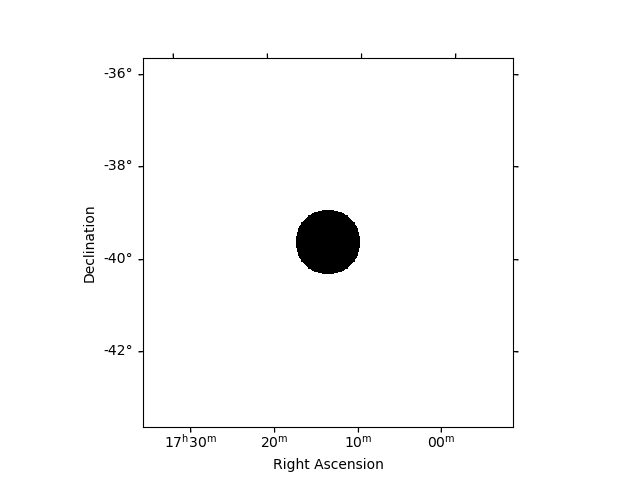

### Makers

In [ ]:
map_maker = MapDatasetMaker()

**Exercise**

Create a SafeMaskMaker that uses a maximum offset of 2.5 deg and an aeff-max of 10 percent.

**[3 marks]**

In [ ]:
## your code here

safe_mask_maker = ...

**Exercise**

Create a RingBackgroundMaker which uses the exclusion radius as inner radius. Do not forget to use the exclusion mask.

**[3 marks]**

In [ ]:
## your code here

ring_bkg_maker = ...

### Loop over Observations and Stack

In [ ]:
map_empty = MapDataset.create(map_geom, 
                              name='empty', 
                              energy_axis_true=energy_axis_true
                             )

In [ ]:
map_stacked = None

for obs in observations:
    map_dataset = map_maker.run(map_empty.copy(name = str(obs.obs_id)), obs)
    map_dataset = safe_mask_maker.run(map_dataset, obs)
    map_dataset = ring_bkg_maker.run(map_dataset)
    
    if map_stacked is None :
        map_stacked = map_dataset.copy(name = 'map stacked')
    else :
        map_stacked.stack(map_dataset)
    
    del map_dataset

In [ ]:
map_stacked.excess.sum_over_axes().plot()

plt.savefig('OnMap.png')

Expected output:

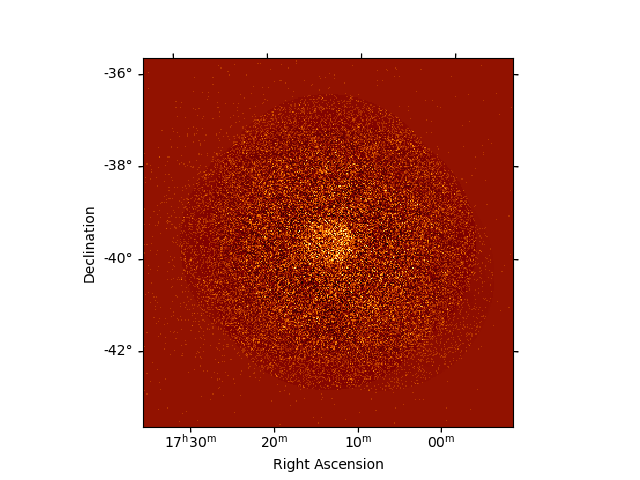

Now we create the RingBackgroundMaker. We can choose the inner radius of the ring, which must be larger than the largest exclusion region, and the width of the ring.

In [ ]:
r_in = np.max([0.4, exclusion_radius.to(u.deg).value])*u.deg

In [ ]:
ring_bkg_maker = RingBackgroundMaker(exclusion_mask=exclusion_mask,
                                     r_in= r_in,
                                     width=0.2*u.deg)

## Excess and Significance Maps
We could calculate the significance in each bin. There is an easy way to do that. We can use gammapy's ExcessMapEstimator.

**Exercise**

Run the ExcessMapEstimator with an oversampling radius of 0.07 deg. Fill the ```excess_map``` and ```significance map``` with the corresponding maps.

**[3 marks]**

In [ ]:
## your code here

excess_map = ...
significance_map = ...

In [ ]:
excess_map.plot(add_cbar = True)

plt.savefig('ExcessMap.png')

Expected output:

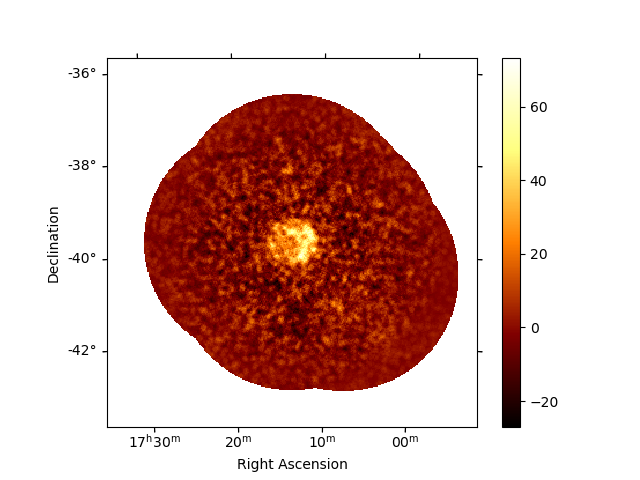z

In [ ]:
significance_map.plot(add_cbar = True)

plt.savefig('SignificanceMap.png')

Expected output:

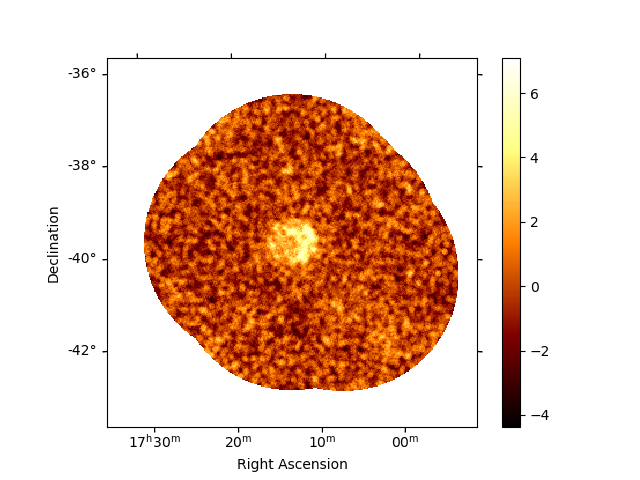

Let's keep the results for later.

In [ ]:
final_results['excess map'] = excess_map.copy()
final_results['significance map'] = significance_map.copy()

## Energy Spectrum
We now want to study the energy distribution of the emission from our object.

In [ ]:
on_region = CircleSkyRegion(center=source_pos, radius=on_region_radius)

We can check on the sky map if the region really encompasses all of the emission. If not, we we need to increase the size. We will use a zoomed version of the significance map.

In [ ]:
skymap = final_results['significance map'].cutout(source_pos, 2*u.deg)

In [ ]:
skymap.plot(add_cbar = True)

on_region.to_pixel(skymap.geom.wcs).plot(color = 'white')

plt.savefig('MapWithOnRegion.png')

**Exercise**

Make sure that the white circle encompasses all of the emission. Otherwise you have to go to the top, change the ```on_region_radius``` and run the analysis again.

**[3 marks]**

Expected output:
    
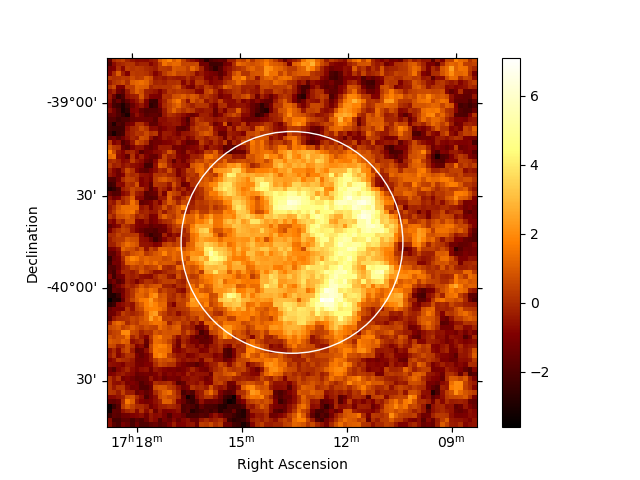

**Exercise**

Create an energy axis with 20 bins from 0.3 to 30 TeV which we will use for the spectrum.

**[3 marks]**

In [ ]:
## your code here

spectrum_energy_axis = ...

In [ ]:
print(spectrum_energy_axis)

Expected output :

```
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 20        
	node type  : edges     
	edges min  : 3.0e-01 TeV
	edges max  : 3.0e+01 TeV
	interp     : log       
```

**Exercise**

Create a ReflectedRegionsBackgroundMaker which uses the exzclusion mask.

**[3 marks]**

In [ ]:
## your code here

reflected_bkg_maker = ...

### Loop over Observations

We need to define a geometry (which is the on source region here) and create an empty SpectrumDataset. We use the same tru-energy axis as for the map.

In [ ]:
spectrum_geom = RegionGeom.create(region=on_region, 
                                  axes=[spectrum_energy_axis]
                                 )

In [ ]:
spectrum_empty =  SpectrumDataset.create(geom=spectrum_geom, 
                                         energy_axis_true=energy_axis_true
                                        )

We need a SpectrumDatasetMaker:

In [ ]:
spectrum_maker = SpectrumDatasetMaker()

In the loop we use the same SafeMaskMaker as before.

In [ ]:
%%time

spectrum_datasets = Datasets()

for obs in observations:
    spectrum_dataset = spectrum_maker.run(spectrum_empty.copy(name = str(obs.obs_id)), obs)
    spectrum_dataset = safe_mask_maker.run(spectrum_dataset, obs)
    spectrum_dataset = reflected_bkg_maker.run(spectrum_dataset, obs)
    
    spectrum_datasets.append(spectrum_dataset)

**Exercise**

Make a plot of the significance map and overplot all off-source regions.

**[3 marks]**

In [ ]:
## your code here

Expected output:

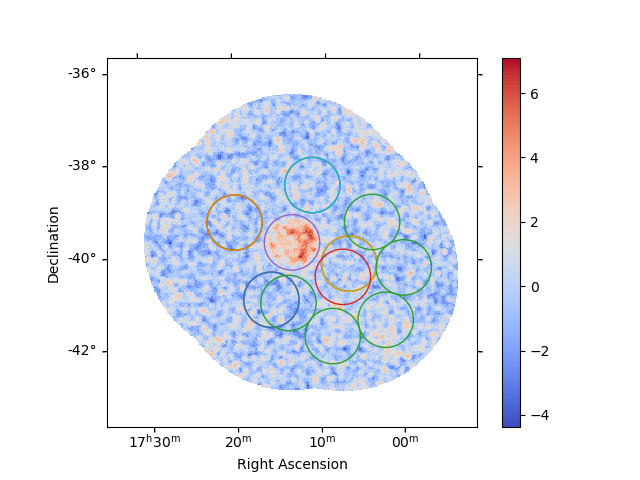

You see that there are much less off-source regions than in the lecture example.

### Excess and Significance

**Exercise**

Find the total excess and the significance of your source. You will need to look at the last line of the cumulative info_table.

**[3 marks]**

In [ ]:
## your code here

excess = ...
significance = ...

In [ ]:
print('excess = {}, significance = {} sigma'.format(excess, significance))

Expected output (Your number can be slightly different) :

```
excess = 2625.7998046875, significance = 22.460462997278317 sigma
```

In [ ]:
final_results['excess'] = excess
final_results['significance'] = significance

### Stacked Spectrum
We will use only a stacked data set for our spectral fits.

In [ ]:
spectrum_dataset = spectrum_datasets.stack_reduce()

In [ ]:
spectrum_dataset.peek()

In the following we will run several fits. We need a fit object for that.

In [ ]:
fit = Fit()

### Fit of a simple Power Law

**Exercise**

Create a power law model. You can use default parameters.

**[1 mark]**

In [ ]:
## your code here

spectral_model = ...

We create a Sky Model.

In [ ]:
model = SkyModel(spectral_model=spectral_model, name="RX J1713")

We assign the model to the dataset.

In [ ]:
spectrum_dataset.models = model

And we run the fit.

In [ ]:
fit.run(spectrum_dataset)

**Exercise**

Check the output. Success must be True and everything has to terminate succesfully. Otherwise our fit result is wrong. If the fit fails, try to run it again. Or change the start parameters and run again. Do not continue with a failed fit!

**[2 marks]**

In [ ]:
spectrum_dataset.plot_fit()

plt.savefig('PLfit.png')

Expected output:

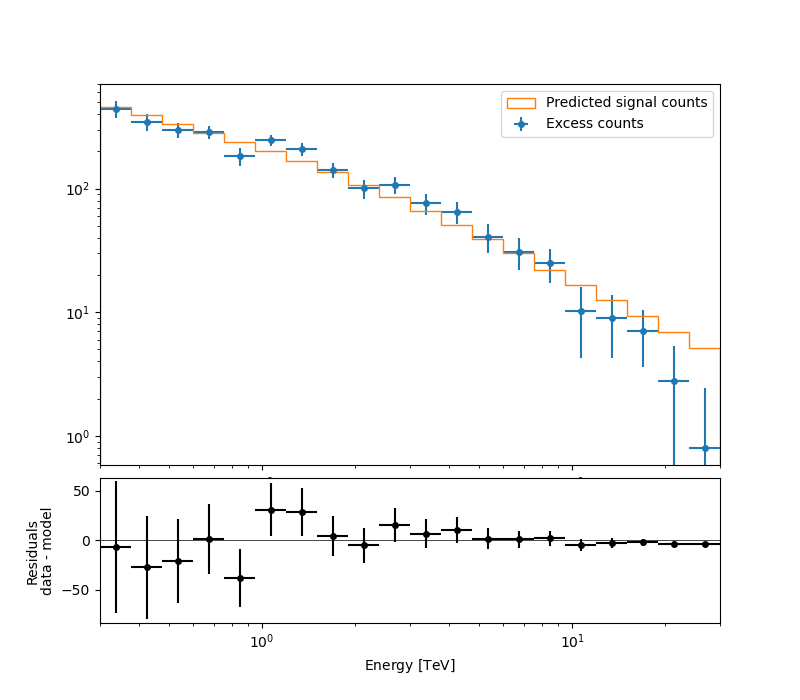

We will make a copy of the model for later use:

In [ ]:
bestmodel_PL = spectrum_dataset.models.copy()

In [ ]:
TS_PL = spectrum_dataset.stat_sum()

### Fit with Power Law with Exponential Cut-Off

**Exercise**

Create an ExpCutoffPowerLawSpectralModel and fit it to the data. Make sure that the fit converges.

**[6 marks]**

In [ ]:
## your code here


In [ ]:
spectrum_dataset.plot_fit()

plt.savefig('ExpPLfit.png')

Expected output:

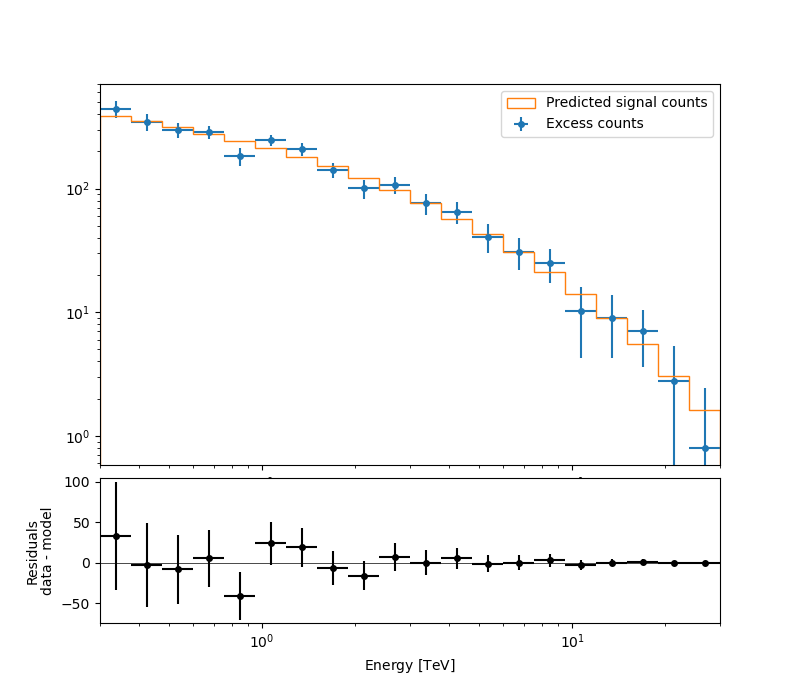

Let's keep the results for later use.

In [ ]:
bestmodel_expPL = spectrum_dataset.models.copy()

In [ ]:
TS_expPL = spectrum_dataset.stat_sum()

### Compare the Models

**Exercise**

Use Wilk's theorem to compare the two fits. Calculate the chi-square probability and accept the model with the cut-off when the probability is smaller than 2.7e-3. Fill ```bestmodel``` with your better model.

**[3 marks]**

In [ ]:
## your code here

bestmodel = ...

Let's set this model as the current model of the Dataset:

In [ ]:
spectrum_dataset.models = bestmodel

In [ ]:
bestmodel.parameters.to_table()

And we store the fit parameters in the final results.

In [ ]:
final_results['fit parameters'] = bestmodel.parameters.to_table()

final_results['model type'] = bestmodel[0].spectral_model.tag[0]

## Flux Points
In the final step we want to create flux points which can be used for later analysis and astrophysical modelling. These points will depend on our best-fit model. Let's check first that we indeed have our best-fit model.

In [ ]:
spectrum_dataset.models[0].spectral_model

We will use the same energy bins as for the fit.

In [ ]:
energy_edges = spectrum_dataset.geoms['geom'].axes['energy'].edges

In [ ]:
fpe = FluxPointsEstimator(energy_edges = energy_edges,
                          selection_optional = ['ul']
                         )

In [ ]:
flux_points = fpe.run(spectrum_dataset)

In [ ]:
flux_points.to_table()

Flux points are often plotted in $E^2 \times dN/dE$:

In [ ]:
flux_points.plot(sed_type = 'e2dnde')

#plt.savefig('Flux_E2dNdE.svg')

**Exercise**

Plot your spectral data points with the best fit model.

**[3 marks]**

In [ ]:
## your code here


Expected output:

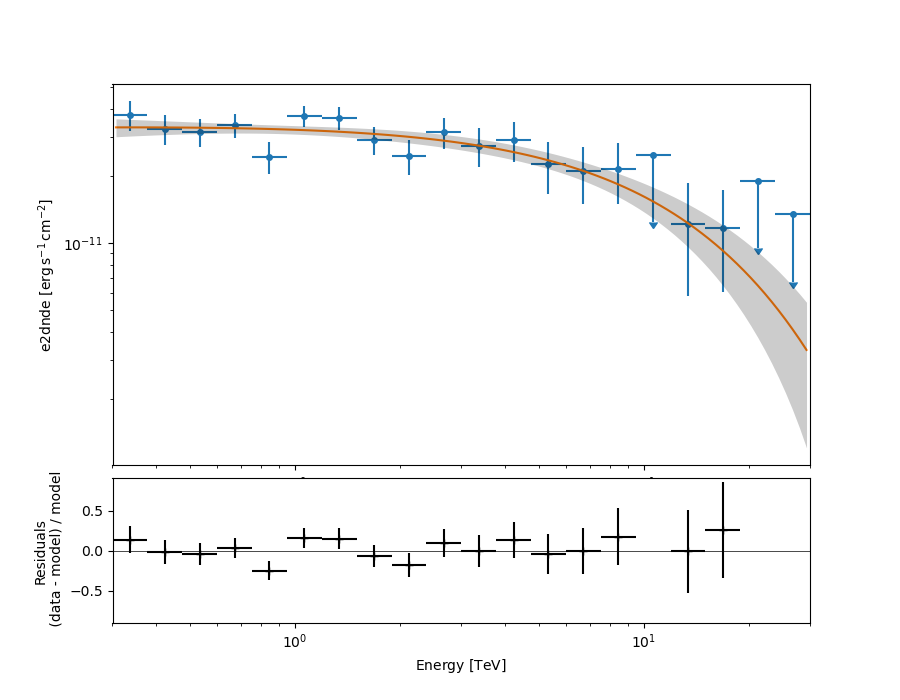

Let's keep that for later.

In [ ]:
final_results['flux points'] = flux_points.to_table()

We can save the points for later use.

In [ ]:
flux_points.write('RXJ1713_spectrum.ecsv',
                  overwrite = True
                 )

You will need to download the file ```RXJ1713_spectrum.ecsv``` and keep it for later use!

## Summary

That's all. Let's see what we have and summarise.

In [ ]:
final_results.keys()

In [ ]:
print('We have found {} runs'. format(len(final_results['run list'])))

In [ ]:
print('We have detected an excess of {:4.1f} gamma rays with a statistical significance of {:3.1f} sigma.'.format(final_results['excess'], final_results['significance']))

In [ ]:
print('The spectrum is best described by a {:s}.'.format(final_results['model type']))

In [ ]:
print('The best fit parameters are:\n', final_results['fit parameters'])

In [ ]:
print('The spectral data points are:\n', final_results['flux points'])

In [ ]:
final_results['excess map'].plot(cmap = 'coolwarm', add_cbar = 'true')

In [ ]:
final_results['significance map'].plot(cmap = 'coolwarm', add_cbar = 'true')

## Sanity Check

Before you submit your work you should make a few checks that everything works fine.

1. Save your notebook as a PDF (File->Save and Export Notebook As->PDF). This document will help you debugging in the next step.
1. Restart the kernel and rerun the entire notebook (Kernel->Restart & Run All). This will delete all variables (but not your code) and rerun the notebook in one go. If this does not go through the end (i.e. you do not see the output of the next cell) then you have to fix it. You will see at which cell the run stopped. A common mistake is using a variable that is defined only at a later stage.
1. You think you fixed everything? Redo step 2 (Kernel->Restart & Run All)

In [ ]:
print('a\bYa\boa\bua\b a\baa\bra\bea\b a\bra\bea\baa\bda\bya\b a\bta\boa\b a\bsa\bua\bba\bma\bia\bta\b.a\b')

Do you see the output of the last cell without explicitly running it? Then the notebook goes through with one kernel restart. You can proceed to submission.
You do not see the output? Go back to step 2 above.

The jupyter notebook goes through all cells with one Kernel Restart & Run all.    **[1 mark]**

## Submission

You have to download and submit 3 files, the jupyter notebook and the two data files.
- Jupyter notebook. File->Download As->Notebook (.ipynb). Save this file on your disk.
- PDF (File->Save and Export Notebook As->PDF)
- The flux point file (```RXJ1713_spectrum.ecsv```)


Congratulations. You have succesfully completed your TeV Data Analysis project.